In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from tqdm import tqdm
import pdb

%matplotlib inline

In [2]:
device = "cpu" if torch.cuda.is_available() else "cuda:0" # если у тебя только CPU, то автоматически device = 'cpu'

## Define target density

In [3]:
class Correlated_gaussian():
    '''
    This class defines correlated gaussian target (2d)
    '''
    def __init__(self, mu, covar):
        self.distr = torch.distributions.MultivariateNormal(loc=mu, covariance_matrix=covar)
        
    def get_logdensity(self, z): # оцениваем log_density в z
        return self.distr.log_prob(z)
    
    def get_samples(self, N): # N - сколько семплов нужно
        return self.distr.sample((N, )) # аргументом должен быть iterable

In [4]:
## Option 1
mu = torch.tensor([10., 3.], device=device, dtype=torch.float32) # тензор -- это объект данных, с которым работает pytorch
covar = torch.tensor([[1., 0.95], [0.95, 1.]], device=device, dtype=torch.float32)

# ## Option 2
# mu = torch.tensor([10., 3.], device=device, dtype=torch.float32) # тензор -- это объект данных, с которым работает pytorch
# covar = torch.tensor([[1., 0.], [0., 1.]], device=device, dtype=torch.float32)

In [5]:
target = Correlated_gaussian(mu, covar)

## Plot samples from the target

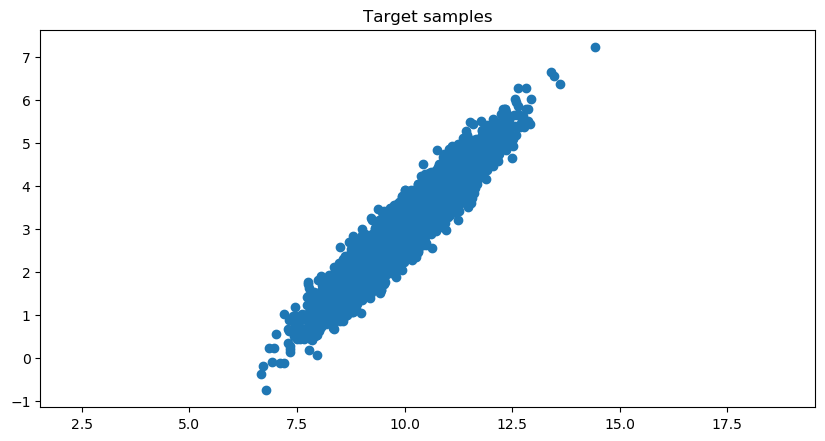

In [6]:
samples = target.get_samples(5000).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Target samples')
plt.axis('equal')
plt.scatter(samples[:, 0], samples[:, 1]);

## Variational inference

Мы выберем простое вариационное распределение: mean-field gaussian

Оно параметризуется двумя векторами -- вектор средних и вектор стандартных отклонений.

In [7]:
# torch.nn.Parameter -- это объект, который далее передается в оптимизатор, по параметрами после производится оптимизация
mu_param = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32))

# обрати внимание, что это std_raw. Std должен быть >0, поэтому мы будем оптимизировать "сырой" вектор,
# который каждый раз будем подставлять в экспоненту

# то есть стартовые параметры, mu_param = 0, 0; std = exp(std_param_raw) = 1, 1
std_param_raw = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32)) 

optimizer = torch.optim.Adam(params=[mu_param, std_param_raw],
                            lr=1e-2) # добавляем параметры в оптимайзер


# стандартное нормальное распределение нужно нам для reparametrization trick (будет в статье про VAE)
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))

In [8]:
batch_size = 1000
num_batches = 10000

KL$(q_{\phi}(z)\|p(z)) = \int_z q_{\phi}(z)\log\frac{q_{\phi}(z)}{p(z)} dz = E_{q_{\phi}(z)}\log q_{\phi}(z) - E _{q_{\phi}(z)}\log p(z)$

Оценки мат.ожиданий из формулы выше будем брать методом Монте-Карло, то есть с помощью семплов

In [9]:
for i in tqdm(range(num_batches)):
    u = std_normal.sample((batch_size, 2)) # это пригодится для reparametrization trick
    
    # Берем семплы из вариационного распределения:
    std = torch.exp(std_param_raw)
    z = mu_param + u * std # собственно, вот этот trick. Можешь пока думать об этом так, что градиент через
                                                # случайные ноды в графе не распространяется
    ## посчитали KL по формуле выше
    KL = -torch.sum(std_param_raw) + std_normal.log_prob(u).sum(1).mean() - target.get_logdensity(z).mean()
    
    # А дальше просто минимизируем KL:
    KL.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if i % 1000 == 0:
        print(f"Current value of KL at batch number {i} is {KL.cpu().detach().numpy()}")

  3%|▎         | 342/10000 [00:00<00:05, 1715.95it/s]

Current value of KL at batch number 0 is 270.96197509765625


 12%|█▏        | 1183/10000 [00:00<00:05, 1679.85it/s]

Current value of KL at batch number 1000 is 18.415498733520508


 22%|██▏       | 2196/10000 [00:01<00:04, 1685.90it/s]

Current value of KL at batch number 2000 is 9.766609191894531


 32%|███▏      | 3213/10000 [00:01<00:04, 1684.01it/s]

Current value of KL at batch number 3000 is 3.805835247039795


 42%|████▏     | 4229/10000 [00:02<00:03, 1683.41it/s]

Current value of KL at batch number 4000 is 1.4976911544799805


 52%|█████▏    | 5241/10000 [00:03<00:02, 1675.52it/s]

Current value of KL at batch number 5000 is 1.192649245262146


 63%|██████▎   | 6255/10000 [00:03<00:02, 1686.06it/s]

Current value of KL at batch number 6000 is 1.1821413040161133


 73%|███████▎  | 7285/10000 [00:04<00:01, 1704.21it/s]

Current value of KL at batch number 7000 is 1.1657670736312866


 83%|████████▎ | 8311/10000 [00:04<00:00, 1702.63it/s]

Current value of KL at batch number 8000 is 1.139306664466858


 93%|█████████▎| 9345/10000 [00:05<00:00, 1725.73it/s]

Current value of KL at batch number 9000 is 1.1496275663375854


100%|██████████| 10000/10000 [00:05<00:00, 1691.59it/s]


### Plot both: samples from variational family and target

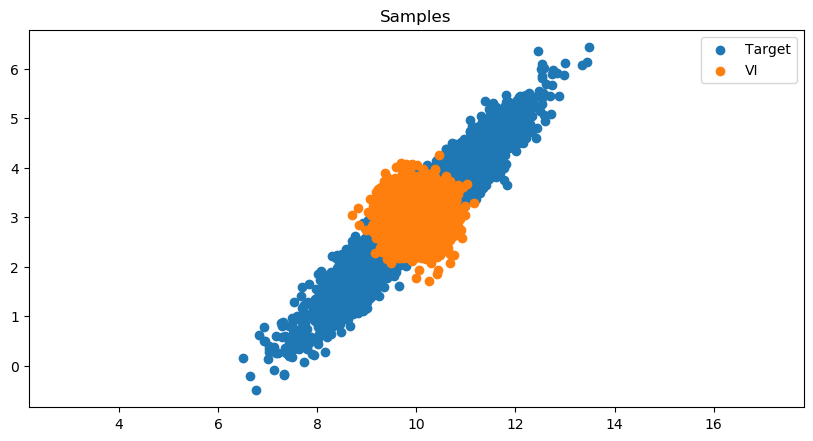

In [10]:
N = 5000

u = std_normal.sample((N, 2)) # это пригодится для reparametrization trick
with torch.no_grad():
    std = torch.exp(std_param_raw)
    sample_varfamily = mu_param + u * std # собственно, вот этот trick. Можешь пока думать об этом так, что градиент через
    
samples_target = target.get_samples(N).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(samples_target[:, 0], samples_target[:, 1], label='Target')
plt.scatter(sample_varfamily[:, 0], sample_varfamily[:, 1], label='VI')
plt.axis('equal')
plt.legend();